## Get the data

In [1]:
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import qstools as qs
import math

import warnings
warnings.simplefilter('ignore')

Alternative: C:\ProgramData\Anaconda3\lib\site-packages\qstools\__init__.py win32


In [2]:
from_DB = True
path_to_feather = "..//..//data//feathers//"

cids = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'JPY', 'NOK', 'NZD', 'SEK', 'USD']
cats = ['ACTIND', 'ACTINDLEAD', 'ACTINDCOIN', 'BCSURV', 'BUILDPERMITS', 'CAPUTIL', 'CARSALES', 'CCSURV', 'CONS',
        'CONSTR', 'EMPL', 'ESI', 'HSTARTS', 'IP', 'IPNEWORDERS', 'MGDP', 'PMICOMP', 'PMIMANU', 'PMISERV', 'REXPORTS',
        'RSV', 'SURVMANU', 'UNEMPL', 'UNEMPLRATE', 'IPMANU', 'IPMINING', 'RSVAL', 'RSVOL', 'WSVOL']

if from_DB:
    dbi = qs.interfaces.DbIndicatorsInterface(username="rsueppel", host="qs-db.cpdsgdta9z0z.eu-west-2.rds.amazonaws.com",
                                              password="l3oT7^WerjY#O!9EGqvL", database="qs_jpm_point_time")
    dfm = dbi.get_series_values(category=cats, cross_section=cids, frequency="m")  # import grade 1 vintages
    dfm.to_feather(f'{path_to_feather}dfm_act_dm.ftr')
else:
    dfm = pd.read_feather(f'{path_to_feather}dfm_act_dm.ftr')

In [3]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5994881 entries, 0 to 5994880
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   cross_section     object 
 1   category_code     object 
 2   adjustment        object 
 3   transformation    object 
 4   release_date      object 
 5   observation_date  object 
 6   value             float64
 7   grading           object 
dtypes: float64(1), object(7)
memory usage: 365.9+ MB


In [4]:
sum(~dfm['transformation'].isnull())  # check that there is no transform

0

In [5]:
dfm['ticker'] = dfm['cross_section'] + '_' + dfm['category_code'] + '_' + dfm['adjustment'] 
np.sort(dfm['ticker'].unique())

array(['AUD_PMIMANU_SA', 'AUD_UNEMPLRATE_SA', 'CAD_HSTARTS_SA',
       'CAD_MGDP_SA', 'CAD_UNEMPLRATE_SA', 'CHF_BCSURV_SA', 'CHF_IP_NSA',
       'CHF_PMICOMP_SA', 'CHF_UNEMPLRATE_SA', 'EUR_CONSTR_SA',
       'EUR_ESI_SA', 'EUR_IP_SA', 'EUR_RSVOL_SA', 'EUR_UNEMPLRATE_SA',
       'GBP_CCSURV_NSA', 'GBP_IP_SA', 'GBP_MGDP_SA', 'GBP_RSVOL_SA',
       'GBP_UNEMPL_SA', 'JPY_IPMANU_SA', 'JPY_IP_NSA', 'JPY_RSVOL_SA',
       'JPY_SURVMANU_NSA', 'JPY_UNEMPLRATE_SA', 'NOK_CONS_SA',
       'NOK_HSTARTS_SA', 'NOK_IPMANU_SA', 'NOK_IPMINING_NSA',
       'NOK_MGDP_SA', 'NOK_RSVOL_SA', 'NOK_UNEMPLRATE_SA',
       'NZD_BCSURV_NSA', 'NZD_BUILDPERMITS_NSA', 'NZD_CAPUTIL_NSA',
       'NZD_PMICOMP_SA', 'SEK_CCSURV_SA', 'SEK_ESI_SA', 'SEK_IPMINING_SA',
       'SEK_PMICOMP_SA', 'SEK_RSVOL_SA', 'SEK_SURVMANU_SA',
       'SEK_UNEMPLRATE_NSA', 'USD_CONS_SA', 'USD_EMPL_SA',
       'USD_HSTARTS_SA', 'USD_IP_SA', 'USD_PMIMANU_SA', 'USD_PMISERV_SA',
       'USD_UNEMPLRATE_SA'], dtype=object)

## Documentation

In [6]:
dbi = qs.interfaces.DbIndicatorsInterface(username="rsueppel", host="qs-db.cpdsgdta9z0z.eu-west-2.rds.amazonaws.com",
                                          password="l3oT7^WerjY#O!9EGqvL", database="qs_jpm_point_time")
docs = dbi.get_series_documentation(category=cats, frequency="m")
docs = docs.sort_values(by = 'cross_section')
# docs.to_csv(f'{path_to_feather}doc_act_dm.csv', index=False)

In [7]:
docs[docs['cross_section']=='AUD']

,cross_section,category_code,adjustment,frequency,documentation
112,AUD,PMIMANU,SA,m,Reference data: (DS: AUPMIM..Q).
164,AUD,UNEMPLRATE,SA,m,Reference data: (MB: aulama0227).


## Functions

In [8]:
def countmap(dfx, start_year, figsize=(12, 12), trueVin = False):
    if trueVin:
        dfx = dfx[dfx['grading'].isin(['1', '1.0', '2.2'])]
    ticks = np.sort(dfx['ticker'].unique())
    dfx.loc[:, 'year'] = pd.DatetimeIndex(dfx.loc[:,'release_date']).year
    dfx = dfx[dfx.year >= start_year]

    dfxx = pd.DataFrame(columns=dfx.columns)
    for tick in ticks:
        dfc = dfx.query('ticker == @tick').reset_index(drop=True)
        releases = dfc[["year", "release_date"]].groupby("year")["release_date"].max().values.tolist()  # use panda series!
        dfcx = dfc[dfc['release_date'].isin(releases)]
        dfxx = dfxx.append(dfcx)

    count_matrix = pd.crosstab(dfxx["year"], dfxx["ticker"])  # per default crosstab counts rows
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(count_matrix, annot=True, fmt="d",
                    cmap="YlGnBu", cbar=False, linewidths=.5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    cds = dfx['cross_section'].unique()[0]
    ax.set_title(cds + ': Vintage lengths for last (available) release in year ', y = 1.1, fontsize=14)

In [9]:
def revlines(df, pots, ncols=2, size = (15, 5), mod = "None"):
    """mod can be DOYA, POYA and None"""
    
    ticks = np.sort(df['ticker'].unique())

    sns.set_style('whitegrid')
    colors = sns.color_palette("Blues", len(pots))
    fig, axes = plt.subplots(nrows=math.ceil(len(ticks)/ncols), ncols=ncols, sharex=True, figsize=size)

    for i in range(len(ticks)):
        tick = ticks[i]
        dfc = df.query('ticker == @tick')
        releases = dfc['release_date'].unique()
        for p in range(len(pots)):  # get releases nearest and before chosen ones
            release = releases[(releases <= pd.to_datetime(pots[p]))].max()
            dfcx_add = dfc[dfc['release_date'].isin([release])]
            if mod == 'POYA':
                dfcx_add['value'] = 100* dfcx_add['value'].pct_change(12)
            if mod == 'DOYA':
                dfcx_add['value'] = dfcx_add['value'].diff(12)
            dfcx = dfcx_add if (p == 0) else dfcx.append(dfcx_add)
        if len(ticks) > 1:
            if axes.ndim == 2:
                axe = axes[math.floor(i / ncols), (i % ncols)]
            else:
                axe = axes[i]
            sns.lineplot(data=dfcx,  x="observation_date", y="value", 
                         hue="release_date", palette=colors, ax=axe)
            axe.set(title=tick, ylabel="", xlabel="")
            if mod != 'None':
                axe.set_title(tick + '_' + mod)
        else:
            sns.lineplot(data=dfcx,  x="observation_date", y="value", 
                         hue="release_date", palette=colors)
            plt.xlabel('')
            plt.ylabel('')
            if mod != 'None':
                plt.title(tick + '_' + mod)
            else:
                plt.title(tick) 

    plt.show()

## AUD

In [10]:
dfm_aud = dfm[dfm['cross_section'] == 'AUD']
np.sort(dfm_aud['ticker'].unique())

array(['AUD_PMIMANU_SA', 'AUD_UNEMPLRATE_SA'], dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

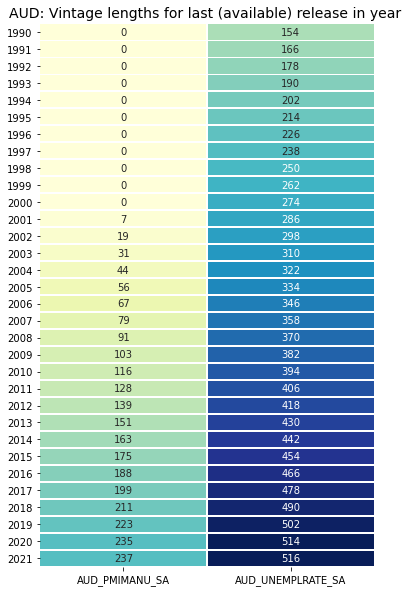

In [11]:
countmap(dfm_aud, 1990, (6, 10))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

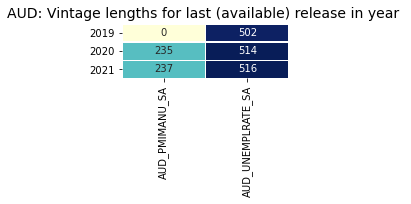

In [12]:
countmap(dfm_aud, 2000, (3, 1), trueVin = True)
plt.show

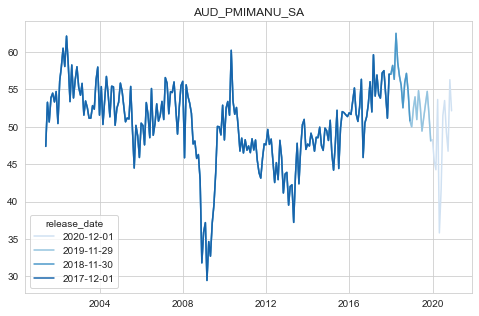

In [13]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_aud['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_aud['ticker'].isin(['AUD_PMIMANU_SA'])
dfm_x = dfm_aud[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5))

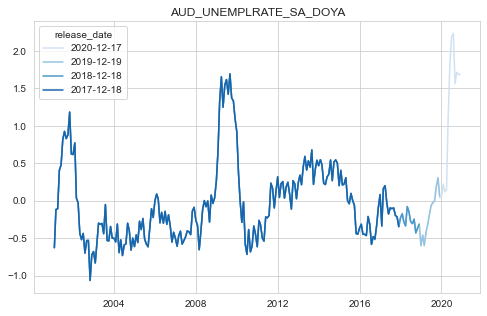

In [14]:
filt2 = dfm_aud['ticker'].isin(['AUD_UNEMPLRATE_SA'])
dfm_x = dfm_aud[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5), mod='DOYA')

## CAD

In [15]:
dfm_cad = dfm[dfm['cross_section'] == 'CAD']
np.sort(dfm_cad['ticker'].unique())

array(['CAD_HSTARTS_SA', 'CAD_MGDP_SA', 'CAD_UNEMPLRATE_SA'], dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

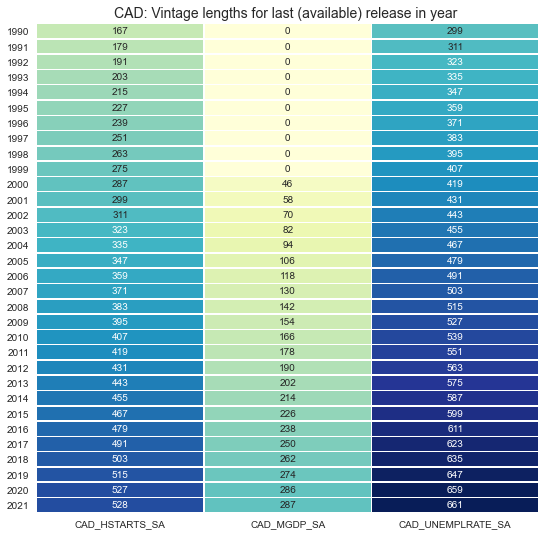

In [16]:
countmap(dfm_cad, 1990, (9, 9))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

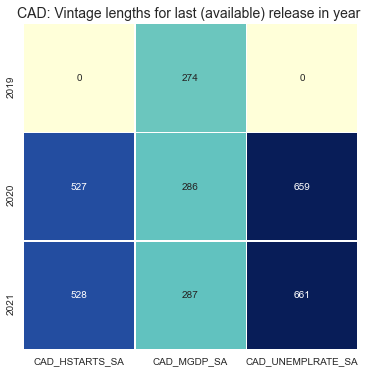

In [17]:
countmap(dfm_cad, 2000, (6, 6), trueVin = True)
plt.show

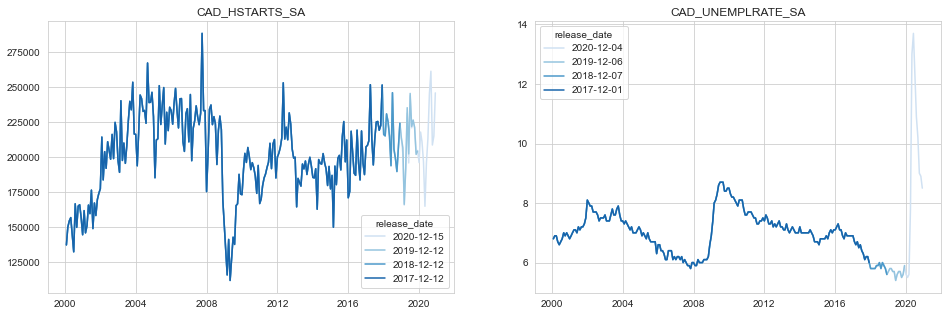

In [18]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_cad['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_cad['ticker'].isin(['CAD_HSTARTS_SA', 'CAD_UNEMPLRATE_SA'])
dfm_x = dfm_cad[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 5))

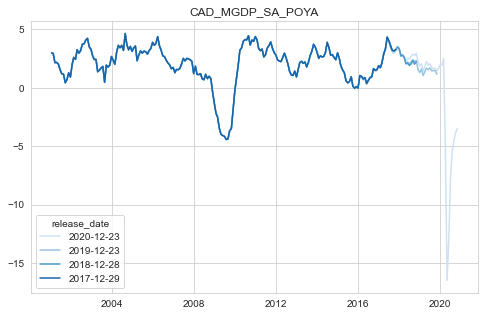

In [19]:
filt2 = dfm_cad['ticker'].isin(['CAD_MGDP_SA'])
dfm_x = dfm_cad[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5), mod='POYA')

## CHF

In [20]:
dfm_chf = dfm[dfm['cross_section'] == 'CHF']
np.sort(dfm_chf['ticker'].unique())

array(['CHF_BCSURV_SA', 'CHF_IP_NSA', 'CHF_PMICOMP_SA',
       'CHF_UNEMPLRATE_SA'], dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

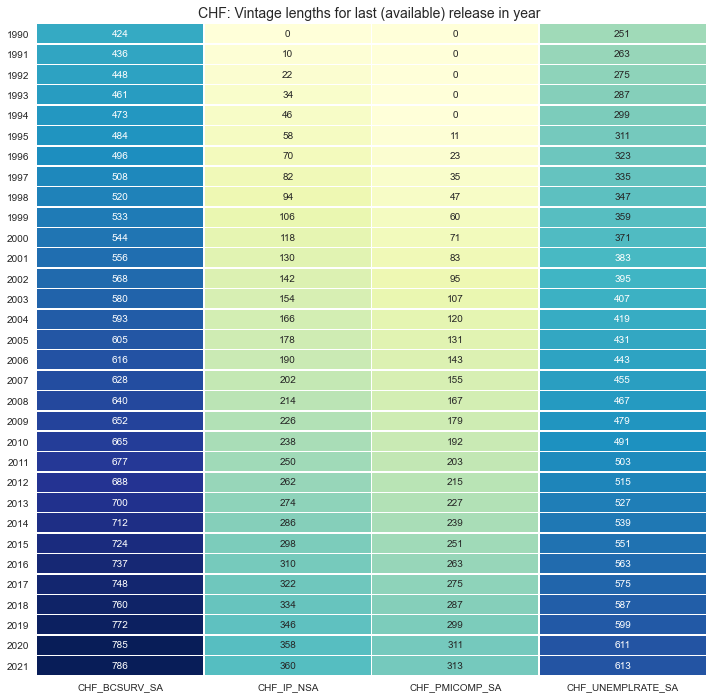

In [21]:
countmap(dfm_chf, 1990, (12, 12))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

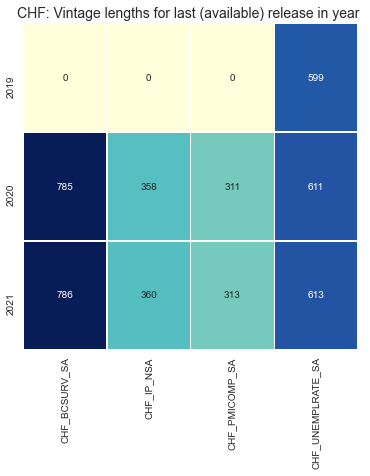

In [22]:
countmap(dfm_chf, 2000, (6, 6), trueVin = True)
plt.show

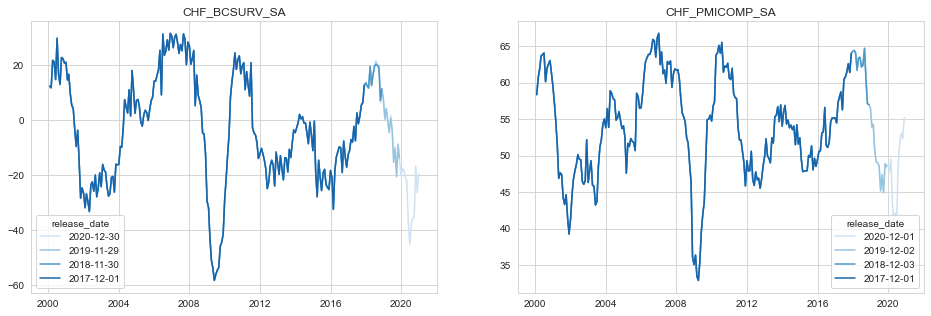

In [67]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_chf['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_chf['ticker'].isin(['CHF_BCSURV_SA', 'CHF_PMICOMP_SA'])
dfm_x = dfm_chf[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 5))

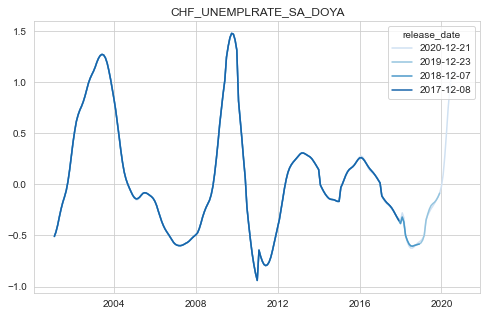

In [68]:
filt2 = dfm_chf['ticker'].isin(['CHF_UNEMPLRATE_SA'])
dfm_x = dfm_chf[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5), mod='DOYA')

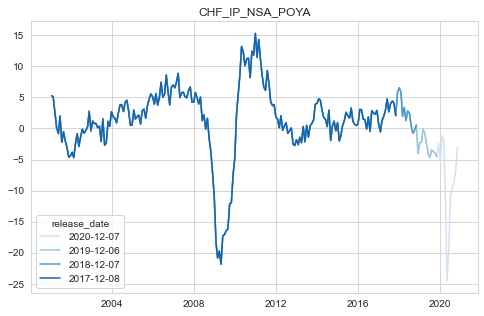

In [24]:
filt2 = dfm_chf['ticker'].isin(['CHF_IP_NSA'])
dfm_x = dfm_chf[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5), mod='POYA')

## EUR

In [25]:
dfm_eur = dfm[dfm['cross_section'] == 'EUR']
np.sort(dfm_eur['ticker'].unique())

array(['EUR_CONSTR_SA', 'EUR_ESI_SA', 'EUR_IP_SA', 'EUR_RSVOL_SA',
       'EUR_UNEMPLRATE_SA'], dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

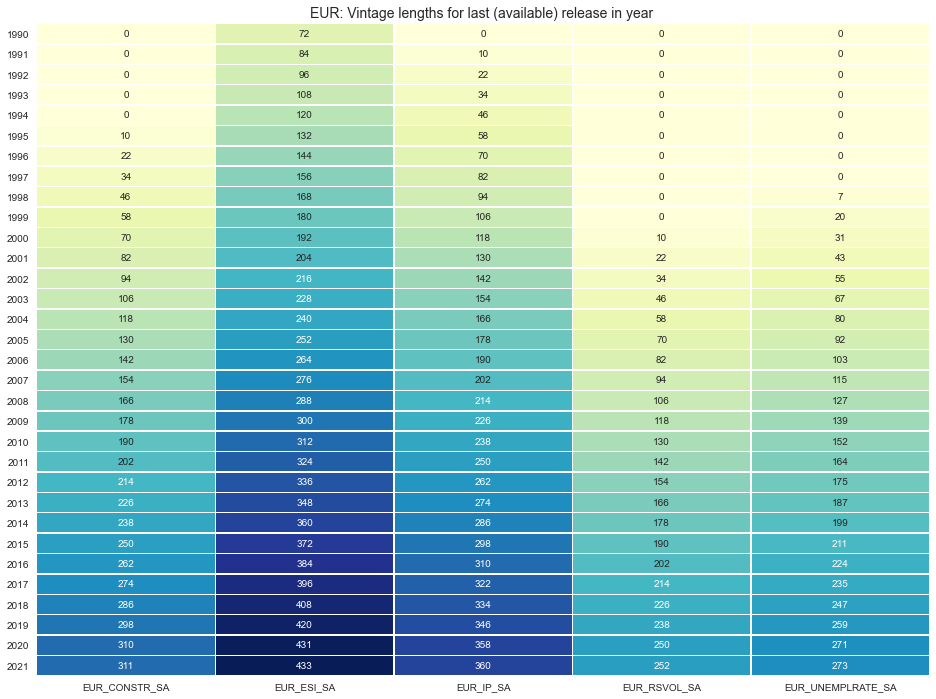

In [26]:
countmap(dfm_eur, 1990, (16, 12))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

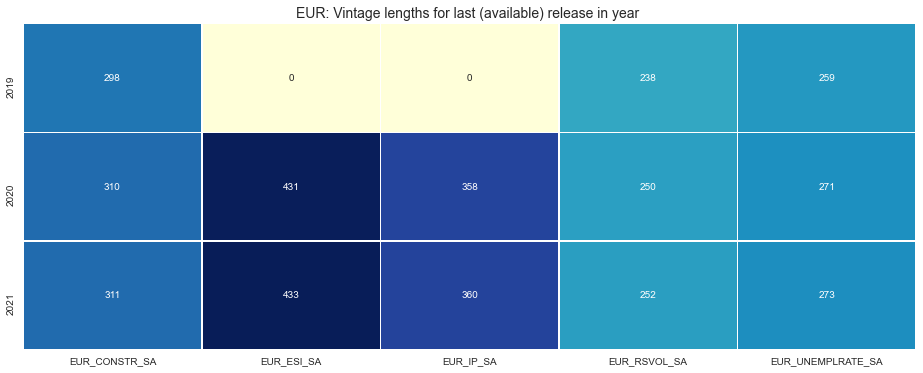

In [27]:
countmap(dfm_eur, 2000, (16, 6), trueVin = True)
plt.show

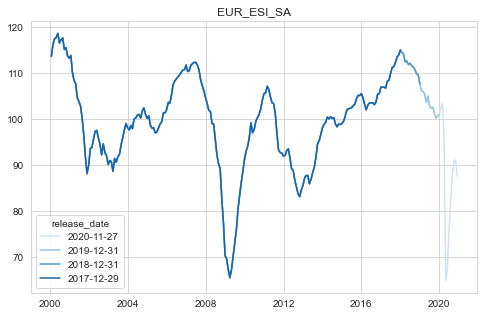

In [28]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_eur['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_eur['ticker'].isin(['EUR_ESI_SA'])
dfm_x = dfm_eur[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5))

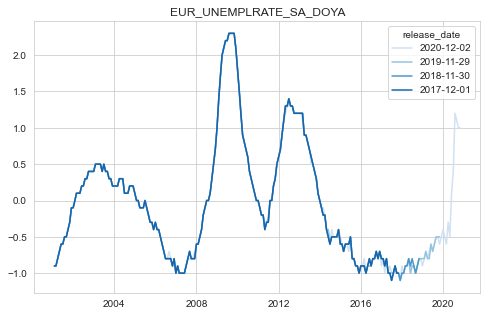

In [29]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_eur['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_eur['ticker'].isin(['EUR_UNEMPLRATE_SA'])
dfm_x = dfm_eur[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5), mod='DOYA')

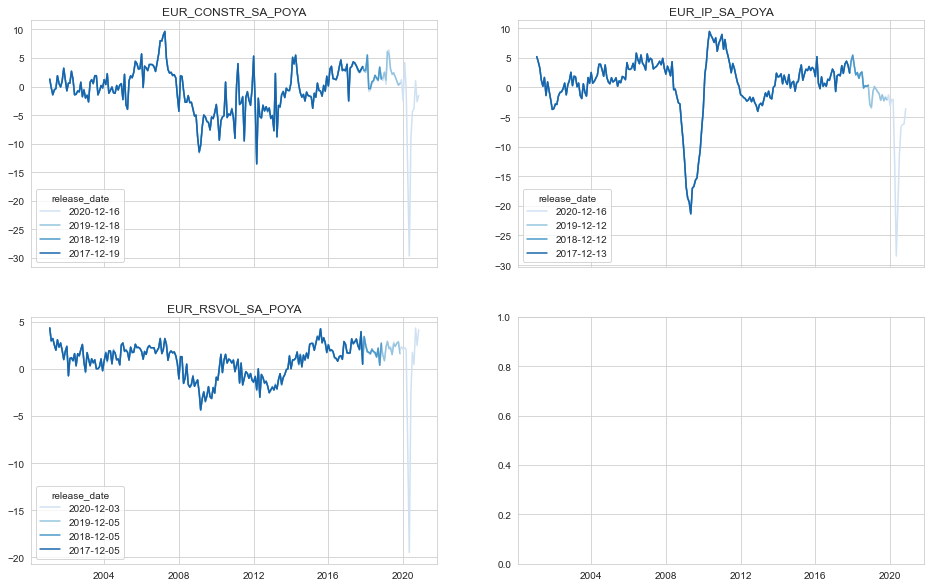

In [30]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_eur['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_eur['ticker'].isin(['EUR_CONSTR_SA', 'EUR_IP_SA', 'EUR_RSVOL_SA'])
dfm_x = dfm_eur[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 10), mod='POYA')

## GBP

In [31]:
dfm_gbp = dfm[dfm['cross_section'] == 'GBP']
np.sort(dfm_gbp['ticker'].unique())

array(['GBP_CCSURV_NSA', 'GBP_IP_SA', 'GBP_MGDP_SA', 'GBP_RSVOL_SA',
       'GBP_UNEMPL_SA'], dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

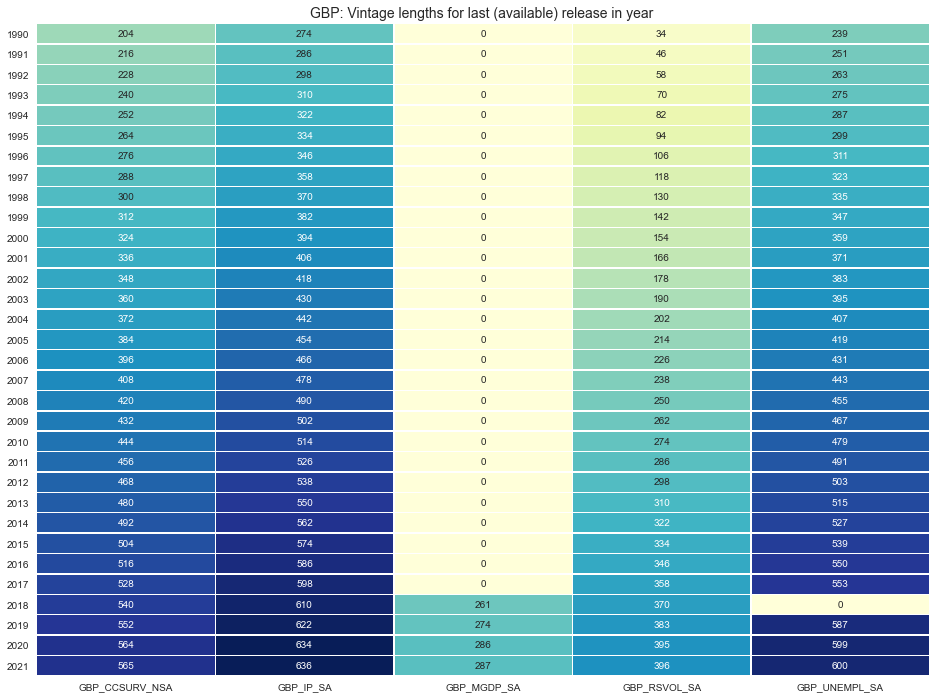

In [32]:
countmap(dfm_gbp, 1990, (16, 12))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

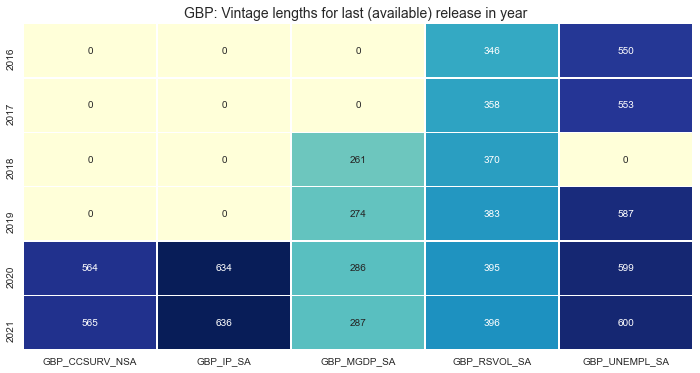

In [33]:
countmap(dfm_gbp, 2000, (12, 6), trueVin = True)
plt.show

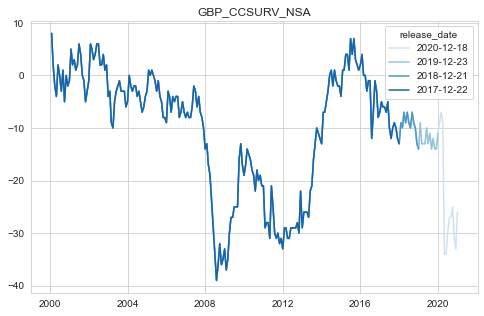

In [34]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_gbp['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_gbp['ticker'].isin(['GBP_CCSURV_NSA'])
dfm_x = dfm_gbp[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5))

In [35]:
# filt2 = dfm_gbp['ticker'].isin(['GBP_UNEMPL_SA'])
# dfm_x = dfm_gbp[filt1 & filt2] 

# revlines(dfm_x, pots=pots, ncols=1, size = (8, 5), mod='DOYA')

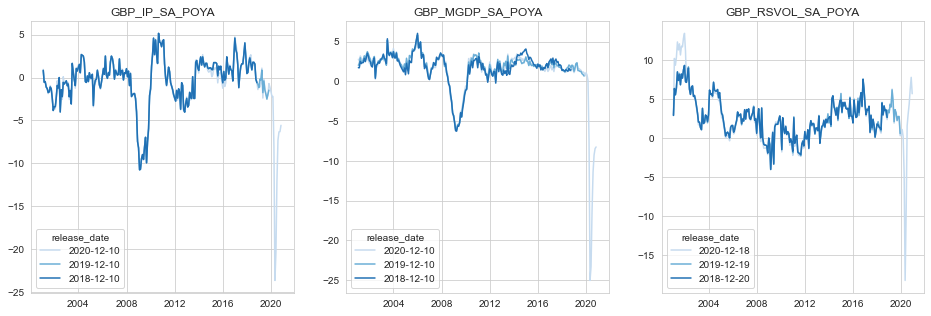

In [36]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31']
filt2 = dfm_gbp['ticker'].isin(['GBP_IP_SA', 'GBP_MGDP_SA', 'GBP_RSVOL_SA'])
dfm_x = dfm_gbp[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=3, size = (16, 5), mod='POYA')

## JPY

In [37]:
dfm_jpy = dfm[dfm['cross_section'] == 'JPY']
np.sort(dfm_jpy['ticker'].unique())

array(['JPY_IPMANU_SA', 'JPY_IP_NSA', 'JPY_RSVOL_SA', 'JPY_SURVMANU_NSA',
       'JPY_UNEMPLRATE_SA'], dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

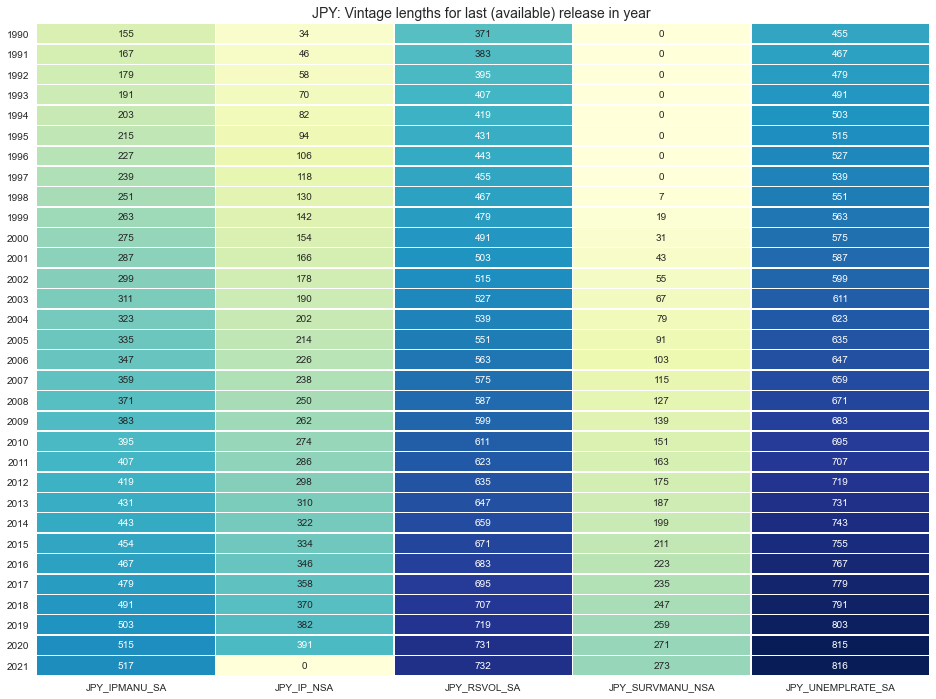

In [38]:
countmap(dfm_jpy, 1990, (16, 12))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

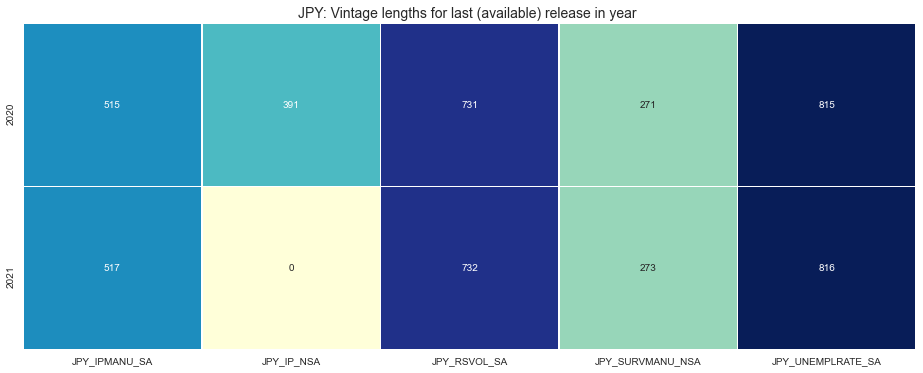

In [39]:
countmap(dfm_jpy, 2000, (16, 6), trueVin = True)
plt.show

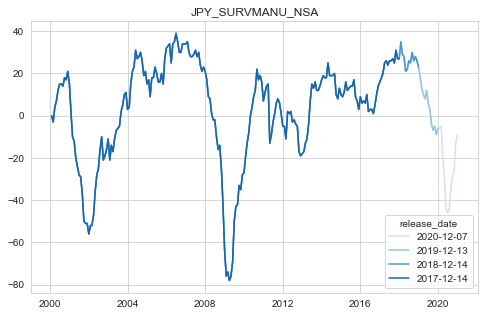

In [40]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_jpy['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_jpy['ticker'].isin(['JPY_SURVMANU_NSA'])
dfm_x = dfm_jpy[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5))

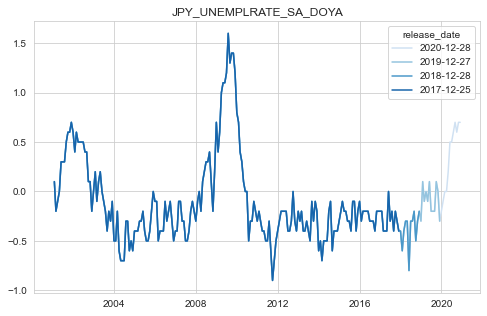

In [41]:
filt2 = dfm_jpy['ticker'].isin(['JPY_UNEMPLRATE_SA'])
dfm_x = dfm_jpy[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5), mod='DOYA')

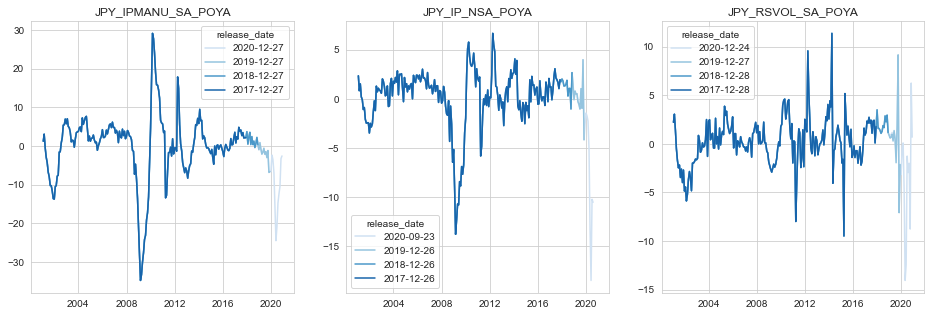

In [42]:
filt2 = dfm_jpy['ticker'].isin(['JPY_IPMANU_SA', 'JPY_IP_NSA', 'JPY_RSVOL_SA'])
dfm_x = dfm_jpy[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=3, size = (16, 5), mod='POYA')

## NOK

In [43]:
dfm_nok = dfm[dfm['cross_section'] == 'NOK']
np.sort(dfm_nok['ticker'].unique())

array(['NOK_CONS_SA', 'NOK_HSTARTS_SA', 'NOK_IPMANU_SA',
       'NOK_IPMINING_NSA', 'NOK_MGDP_SA', 'NOK_RSVOL_SA',
       'NOK_UNEMPLRATE_SA'], dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

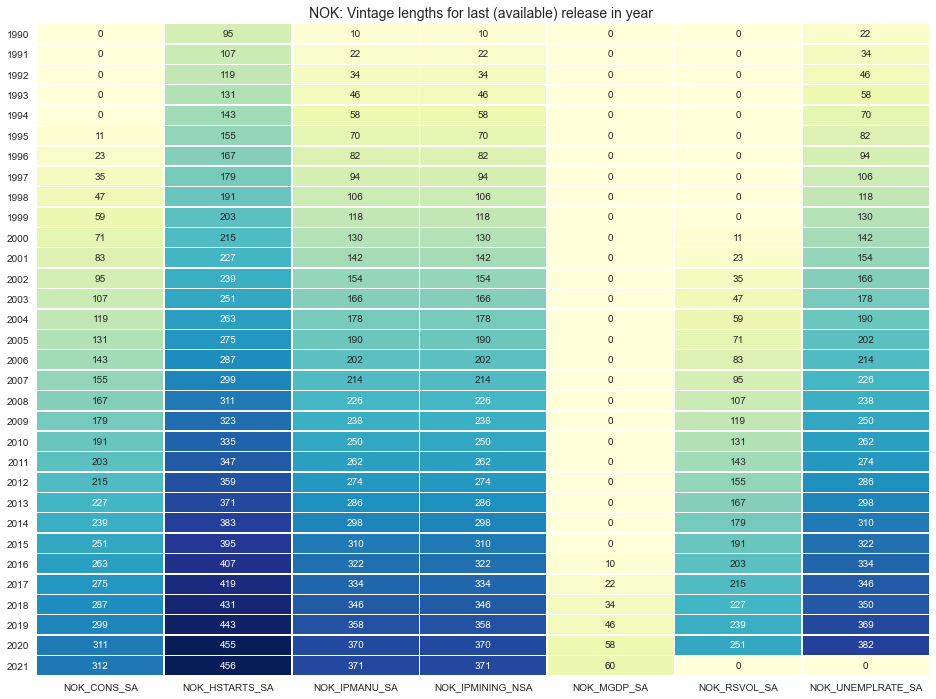

In [44]:
countmap(dfm_nok, 1990, (16, 12))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

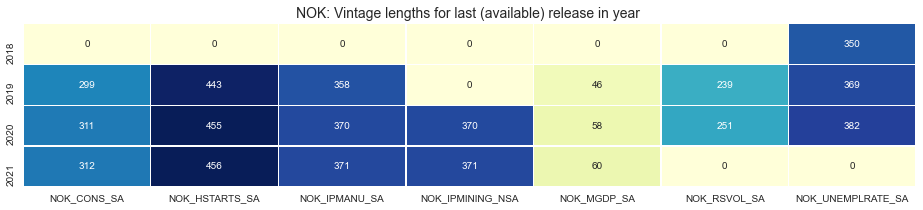

In [45]:
countmap(dfm_nok, 2000, (16, 3), trueVin = True)
plt.show

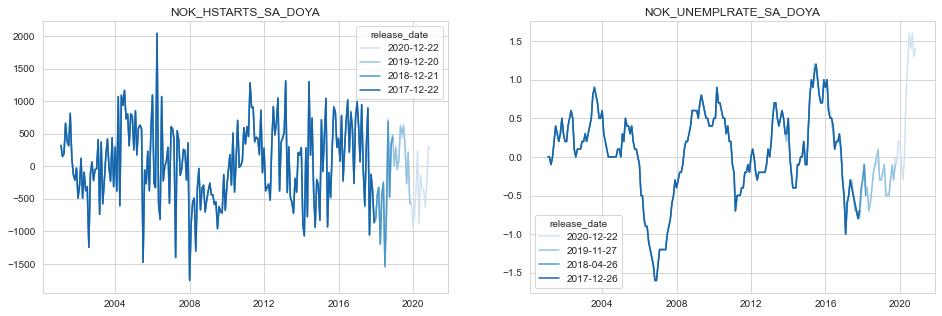

In [46]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_nok['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_nok['ticker'].isin(['NOK_HSTARTS_SA', 'NOK_UNEMPLRATE_SA'])
dfm_x = dfm_nok[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 5), mod='DOYA')

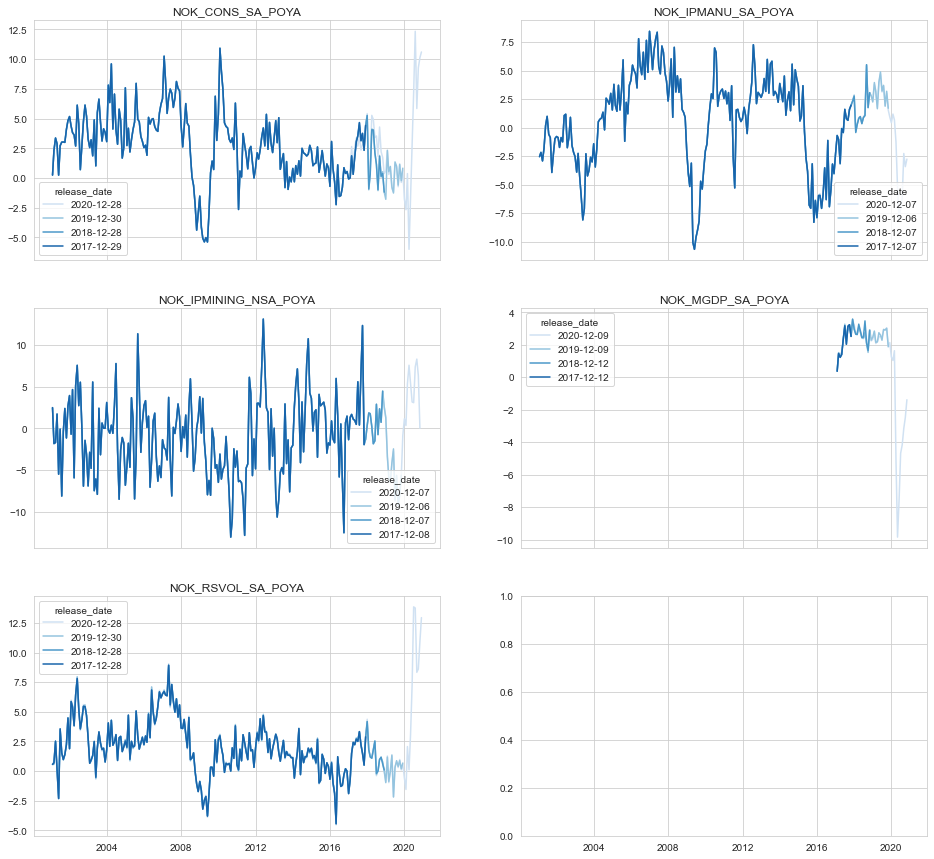

In [47]:
filt2 = dfm_nok['ticker'].isin(['NOK_CONS_SA', 'NOK_IPMANU_SA','NOK_IPMINING_NSA', 'NOK_MGDP_SA', 'NOK_RSVOL_SA'])
dfm_x = dfm_nok[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 15), mod='POYA')

## NZD

In [48]:
dfm_nzd = dfm[dfm['cross_section'] == 'NZD']
np.sort(dfm_nzd['ticker'].unique())

array(['NZD_BCSURV_NSA', 'NZD_BUILDPERMITS_NSA', 'NZD_CAPUTIL_NSA',
       'NZD_PMICOMP_SA'], dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

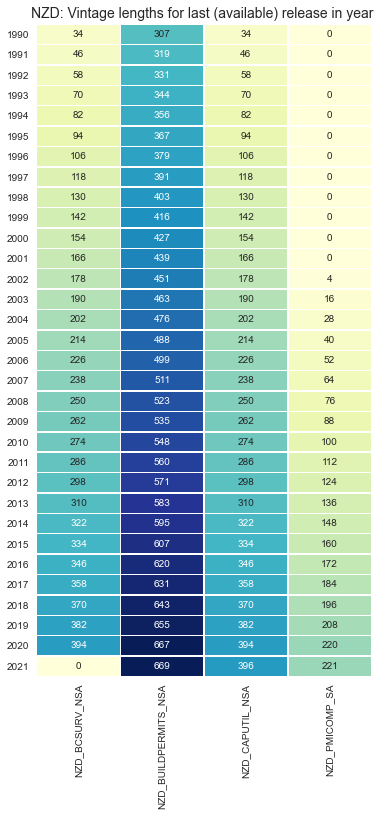

In [49]:
countmap(dfm_nzd, 1990, (6, 12))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

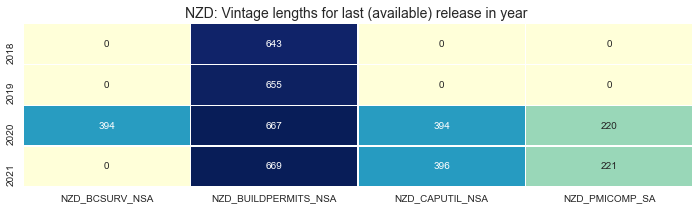

In [50]:
countmap(dfm_nzd, 2000, (12, 3), trueVin = True)
plt.show

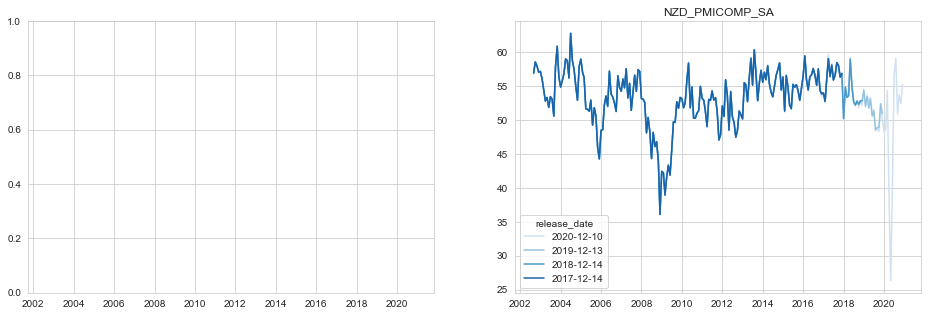

In [51]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_nzd['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_nzd['ticker'].isin(['NZD_PMICOMP_SA', 'NZD_ACTINDLEAD_NSA'])
dfm_x = dfm_nzd[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 5))

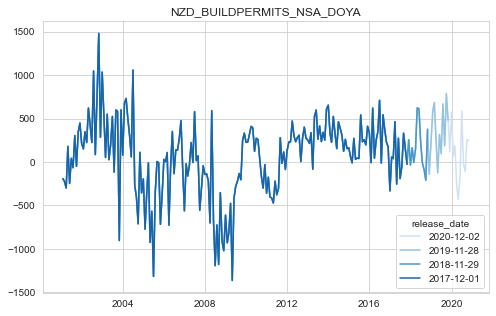

In [52]:
filt2 = dfm_nzd['ticker'].isin(['NZD_BUILDPERMITS_NSA'])
dfm_x = dfm_nzd[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5), mod='DOYA')

## SEK

In [53]:
dfm_sek = dfm[dfm['cross_section'] == 'SEK']
np.sort(dfm_sek['ticker'].unique())

array(['SEK_CCSURV_SA', 'SEK_ESI_SA', 'SEK_IPMINING_SA', 'SEK_PMICOMP_SA',
       'SEK_RSVOL_SA', 'SEK_SURVMANU_SA', 'SEK_UNEMPLRATE_NSA'],
      dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

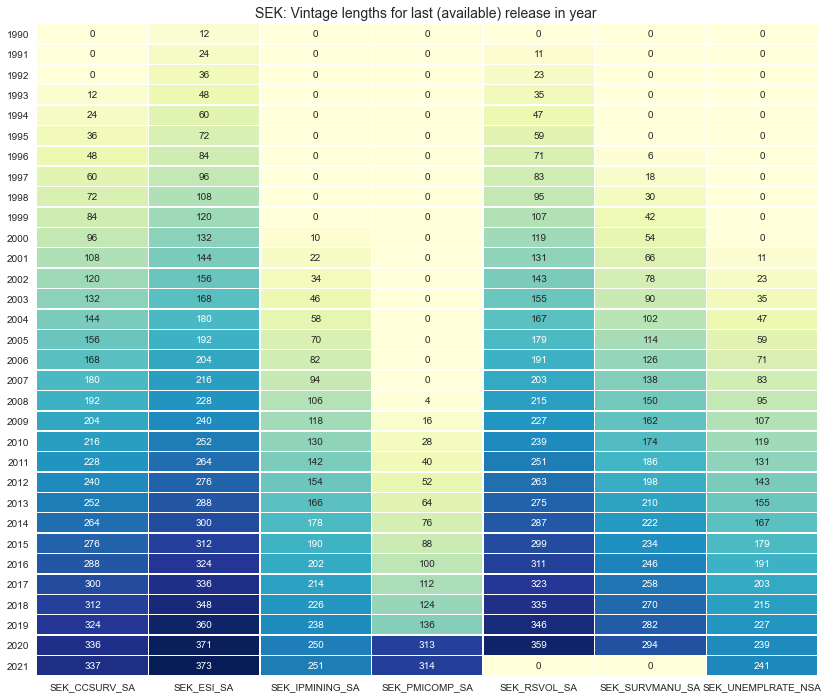

In [54]:
countmap(dfm_sek, 1990, (14, 12))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

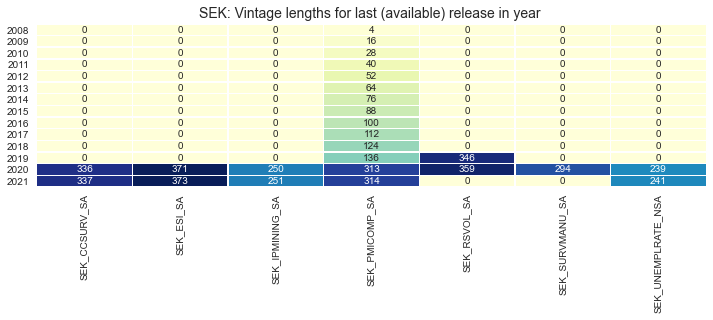

In [55]:
countmap(dfm_sek, 2000, (12, 3), trueVin = True)
plt.show

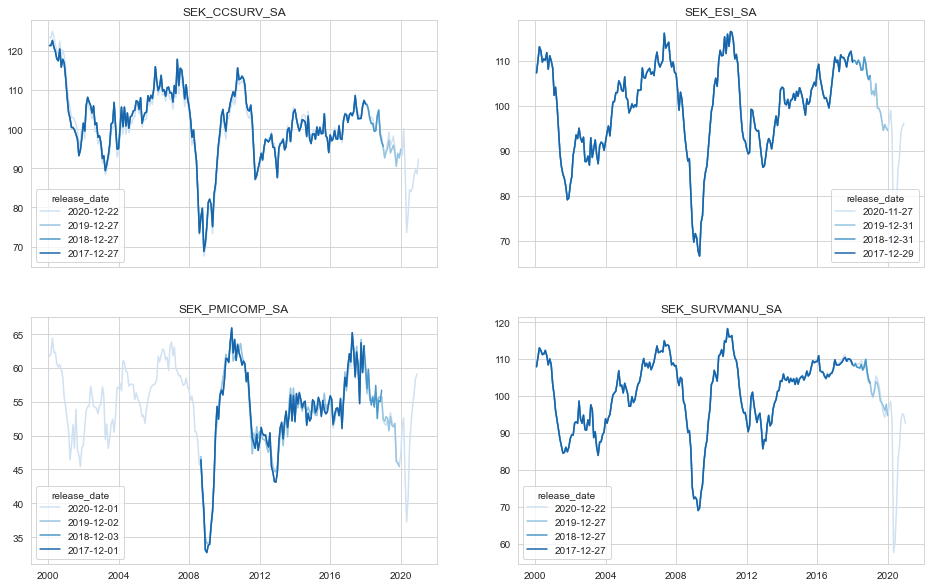

In [56]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_sek['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_sek['ticker'].isin(['SEK_CCSURV_SA', 'SEK_ESI_SA', 'SEK_PMICOMP_SA', 'SEK_SURVMANU_SA'])
dfm_x = dfm_sek[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 10))

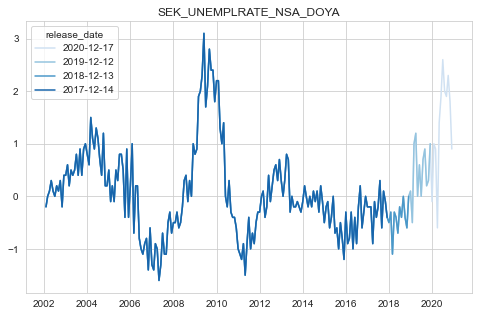

In [57]:
filt2 = dfm_sek['ticker'].isin(['SEK_UNEMPLRATE_NSA'])
dfm_x = dfm_sek[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5), mod='DOYA')

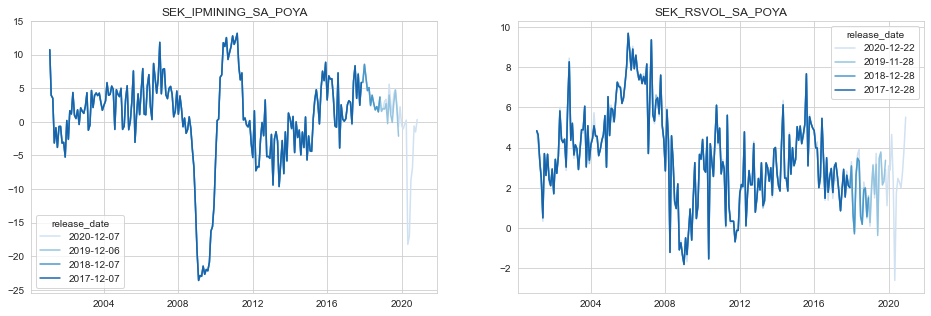

In [58]:
filt2 = dfm_sek['ticker'].isin(['SEK_IPMINING_SA', 'SEK_RSVOL_SA'])
dfm_x = dfm_sek[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 5), mod='POYA')

## USD

In [59]:
dfm_usd = dfm[dfm['cross_section'] == 'USD']
np.sort(dfm_usd['ticker'].unique())

array(['USD_CONS_SA', 'USD_EMPL_SA', 'USD_HSTARTS_SA', 'USD_IP_SA',
       'USD_PMIMANU_SA', 'USD_PMISERV_SA', 'USD_UNEMPLRATE_SA'],
      dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

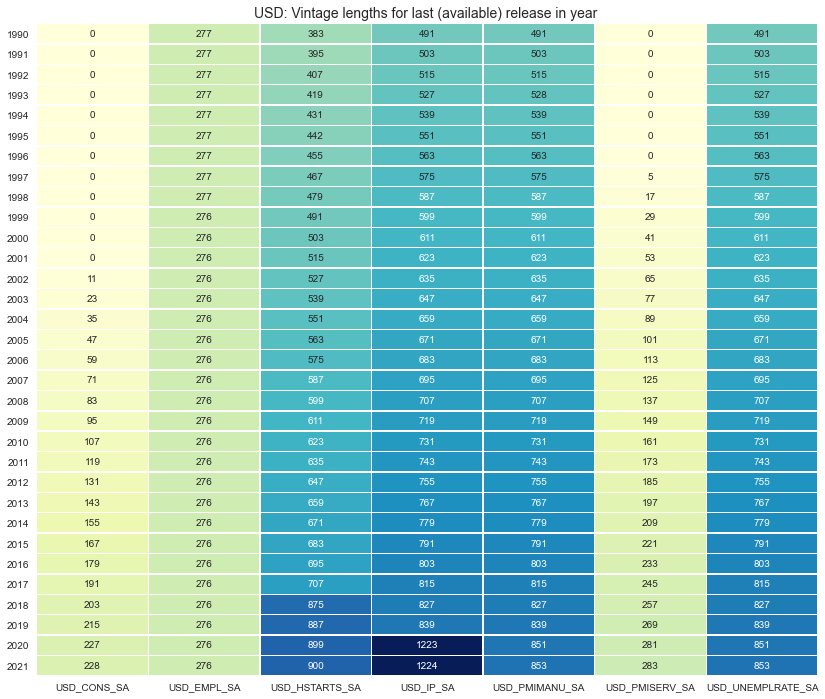

In [60]:
countmap(dfm_usd, 1990, (14, 12))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

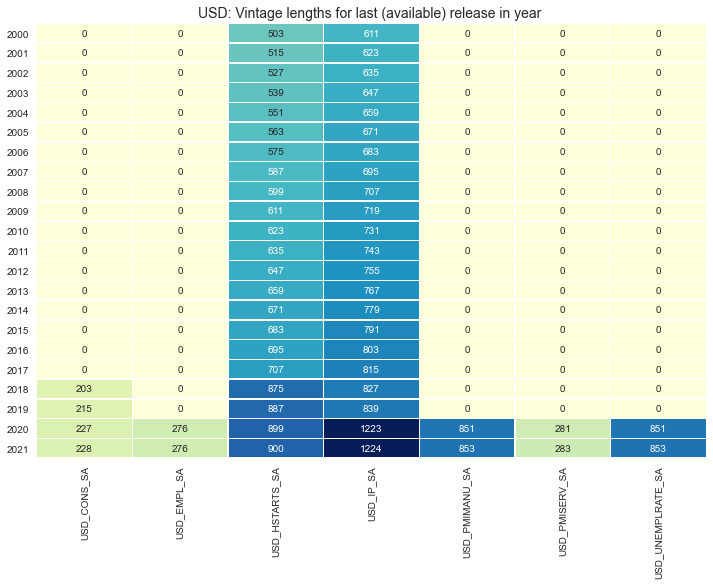

In [65]:
countmap(dfm_usd, 2000, (12, 8), trueVin = True)
plt.show

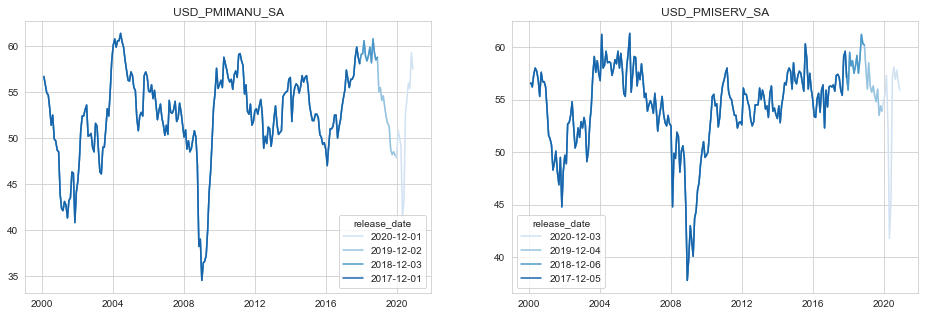

In [62]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_usd['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_usd['ticker'].isin(['USD_PMIMANU_SA', 'USD_PMISERV_SA'])
dfm_x = dfm_usd[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 5))

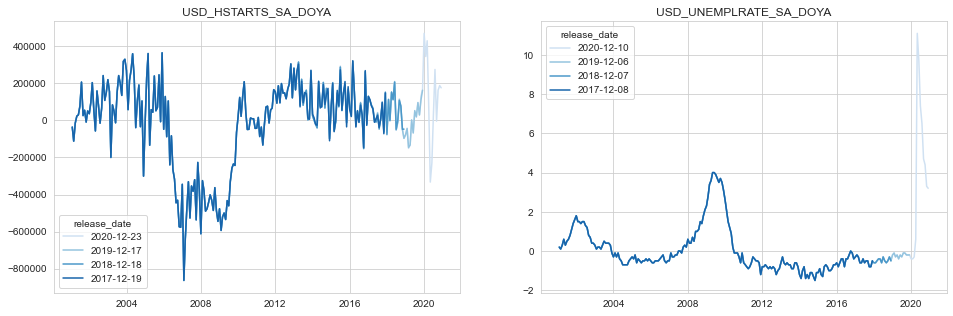

In [63]:
filt2 = dfm_usd['ticker'].isin(['USD_HSTARTS_SA', 'USD_UNEMPLRATE_SA'])
dfm_x = dfm_usd[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 5), mod='DOYA')

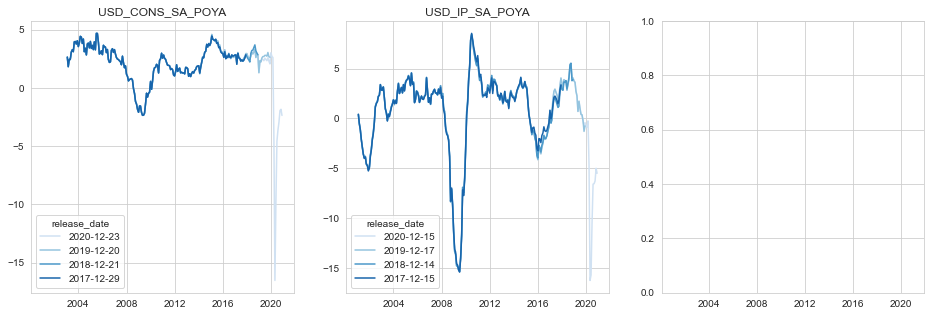

In [64]:
filt2 = dfm_usd['ticker'].isin(['USD_CONS_SA', 'USD_EMPL_SA', 'USD_IP_SA'])
dfm_x = dfm_usd[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=3, size = (16, 5), mod='POYA')